# Data import and preprocessing

Data is imported from the Stanford University HIV Drug resistance database https://hivdb.stanford.edu/pages/genopheno.dataset.html

In [2]:
from urllib.request import urlretrieve
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor


In [3]:
# Stanford databases:
# High quality and full datasets

urls = ["https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/PI_DataSet.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/NRTI_DataSet.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/NNRTI_DataSet.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/INI_DataSet.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/PI_DataSet.Full.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/NRTI_DataSet.Full.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/NNRTI_DataSet.Full.txt",
        "https://hivdb.stanford.edu/_wrapper/download/GenoPhenoDatasets/INI_DataSet.Full.txt"]

data_storage = r".\data"

#importing hq urls
for url in urls:
    filename = url.split("/")[-1]

    urlretrieve(url, data_storage + "\\" + filename)



In [3]:
# table for the encoding of the resistance testing into three classes: "susceptible", "intermediate-level resistant", "high-level resistant" with lower and upper thresholds

thresholds = [
    [3, 15],    # FPV
    [3, 15],    # ATV
    [3, 15],    # IDV
    [9, 55],    # LPV
    [3, 6],     # NFV
    [3, 15],    # SQV
    [2, 8],     # TPV
    [10, 90],   # DRV
    [5, 25],    # X3TC
    [2, 6],     # ABC
    [3, 15],    # AZT
    [1.5, 3],   # D4T
    [1.5, 3],   # DDI
    [1.5, 3],   # TDF
    [3, 10],    # EFV
    [3, 10],    # NVP
    [3, 10],    # ETR
    [3, 10],    # RPV
]

# Define row and column names
index = ["FPV","ATV","IDV","LPV","NFV","SQV","TPV","DRV",
         "3TC","ABC","AZT","D4T","DDI","TDF",
         "EFV","NVP","ETR","RPV"]
columns = ["lower", "upper"]

# Create DataFrame
cutoff_df = pd.DataFrame(thresholds, index=index, columns=columns)

print(cutoff_df.head())

     lower  upper
FPV    3.0     15
ATV    3.0     15
IDV    3.0     15
LPV    9.0     55
NFV    3.0      6


In [3]:
# Reading in and processing high quality File

df = pd.read_csv("data\\PI_DataSet.txt", sep='\t')
#print(df)
df = df.iloc[:,1:-1]
#print(df2)

#Checking how much data is available for each drug
print(df.loc[:,"FPV":"DRV"].count())

#list of current drugs of the dataset
drugs = [drug for drug in list(df.columns) if not drug.startswith("P") ]

#creating the one hot encoding for the features
enc = OneHotEncoder(handle_unknown='error')

enc.fit(df.loc[:,[drug for drug in list(df.columns) if drug.startswith("P")]])

print(enc.categories_)


FPV    2246
ATV    1656
IDV    2297
LPV    1999
NFV    2344
SQV    2298
TPV    1345
DRV    1116
dtype: int64
[array(['-', '.'], dtype=object), array(['-', '.', 'Q*', 'V'], dtype=object), array(['-', '.', 'F', 'IT', 'IV', 'L', 'M', 'V'], dtype=object), array(['-', '.', 'A', 'D', 'P', 'PS', 'S', 'TA', 'TN', 'TP', 'TS'],
      dtype=object), array(['-', '.', 'F', 'LF', 'LH', 'LI', 'LV'], dtype=object), array(['-', '.', 'GV', 'P', 'R', 'S', 'W*', 'WC', 'WL', 'WLS', 'WR', 'WS',
       'X'], dtype=object), array(['-', '.', 'E', 'K', 'QH', 'QK', 'QR', 'R'], dtype=object), array(['-', '.', 'Q', 'R*', 'RG', 'RQ'], dtype=object), array(['-', '.', 'PAS', 'PL', 'PS', 'X'], dtype=object), array(['-', '.', 'C', 'CF', 'F', 'FI', 'FIV', 'FV', 'H', 'I', 'IF', 'IM',
       'IST', 'IT', 'IV', 'LF', 'LFI', 'LFV', 'LI', 'LIV', 'LR', 'LV',
       'M', 'R', 'S', 'V', 'VF', 'VI', 'X', 'Y'], dtype=object), array(['-', '.', 'I', 'IL', 'IT', 'L', 'LI', 'VA', 'VF', 'VG', 'VI',
       'VIL', 'VL'], dtype=object), 

In [6]:
#print(drug)
drug = 'DRV'

tmp_drugs = drugs.copy()
#print(tmp_drugs)
tmp_drugs.remove(drug)
#print(tmp_drugs)
last_col = list(df.columns)[-1]
dataframe = df.drop(tmp_drugs, axis=1)

#print(dataframe.head())

dataframe = dataframe.dropna()

# encoding the levels of susceptibility as 0 for susceptible, 1 as partly resistant and 2 as compeltly resistant
dataframe.loc[dataframe[drug] < cutoff_df.loc[drug, "lower"], drug + "_level"] = 0
dataframe.loc[dataframe[drug] >= cutoff_df.loc[drug, "upper"], drug + "_level"] = 2
dataframe.loc[(dataframe[drug] >= cutoff_df.loc[drug, "lower"]) & (dataframe[drug] < cutoff_df.loc[drug, "upper"]), drug + "_level"] = 1

#print(dataframe.head())

X, y = dataframe.drop([drug, drug + "_level"], axis=1), np.array(dataframe[drug + "_level"])

#print(X)

X_trafo = enc.transform(X).toarray()

print(X_trafo.shape)

print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_trafo, y, test_size=0.33, random_state=42)


(1116, 1056)
(1116,)


In [12]:

# Train and evaluate TabPFN
y_pred = TabPFNClassifier(random_state=42, ignore_pretraining_limits=True).fit(X_train, y_train).predict_proba(X_test)

# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1], multi_class='ovr')
print(f"TabPFN ROC AUC: {score:.4f}")


C:\Users\flori\anaconda3\Lib\site-packages\tabpfn\classifier.py:422: UserWarning: Number of features 1056 is greater than the maximum Number of features 500 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


TabPFN ROC AUC: 0.9752


In [7]:
#ROC AUC without one hot encoding, took around 19 min for FVR: 0.9506
##ROC AUC without one hot encoding, took around 5 min 30 s for DVR: 0.9728
# ROC AUC with one hot encoding, took around 36 min 28 s for DVR: 0.9752

# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1], multi_class='ovr')
print(f"TabPFN ROC AUC: {score:.4f}")
'''
# Calculate ROC AUC (handles both binary and multiclass)
score = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1], multi_class='ovo', average='macro')
print(f"TabPFN ROC AUC: {score:.4f}")'''

TabPFN ROC AUC: 0.9752


'\n# Calculate ROC AUC (handles both binary and multiclass)\nscore = roc_auc_score(y_test, y_pred if len(np.unique(y)) > 2 else y_pred[:, 1], multi_class=\'ovo\', average=\'macro\')\nprint(f"TabPFN ROC AUC: {score:.4f}")'

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

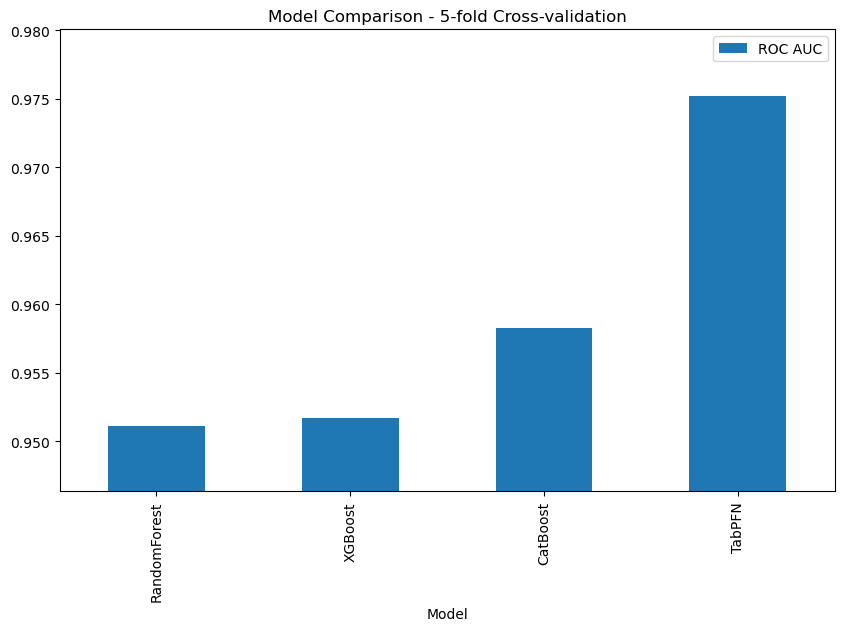

In [13]:
# Define models
models = [
    #('TabPFN', TabPFNClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X_trafo, y, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}
scores.update({'TabPFN':score})

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

In [5]:
#print(drugs)

#going through the drugs and splitting them to test and training depending on the drug

for drug in drugs:
    #print(drug)
    tmp_drugs = drugs.copy()
    #print(tmp_drugs)
    tmp_drugs.remove(drug)
    #print(tmp_drugs)
    last_col = list(df.columns)[-1]
    dataframe = df.drop(tmp_drugs, axis=1)

    #print(dataframe.head())

    dataframe = dataframe.dropna()

    # encoding the levels of susceptibility as 0 for susceptible, 1 as partly resistant and 2 as compeltly resistant
    dataframe.loc[dataframe[drug] < cutoff_df.loc[drug, "lower"], drug + "_level"] = 0
    dataframe.loc[dataframe[drug] >= cutoff_df.loc[drug, "upper"], drug + "_level"] = 2
    dataframe.loc[(dataframe[drug] >= cutoff_df.loc[drug, "lower"]) & (dataframe[drug] < cutoff_df.loc[drug, "upper"]), drug + "_level"] = 1

    #print(dataframe.head())

    X, y = dataframe.drop([drug, drug + "_level"], axis=1), np.array(dataframe[drug + "_level"])

    print(X)

    X_trafo = enc.transform(X).toarray()

    print(X_trafo.shape)

    #print(y)
'''
    # Convert all categorical columns to numeric
    for col in X.select_dtypes(['category']).columns:
        X[col] = X[col].cat.codes

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
'''

     P1 P2 P3 P4 P5 P6 P7 P8 P9 P10  ... P90 P91 P92 P93 P94 P95 P96 P97 P98  \
0     -  -  -  -  -  -  -  -  -   -  ...   -   -   -   -   -   -   -   -   -   
1     -  -  -  -  -  -  -  -  -   -  ...   -   -   -   -   -   -   -   -   -   
2     -  -  -  -  -  -  -  -  -   -  ...   -   -   -   -   -   -   -   -   -   
3     -  -  -  -  -  -  -  -  -   R  ...   -   -   -   -   -   -   -   -   -   
4     -  -  -  -  -  -  -  -  -   I  ...   M   -   -   -   -   -   -   -   -   
...  .. .. .. .. .. .. .. .. ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2389  -  -  -  -  -  -  -  -  -   I  ...   M   -   -   L   -   -   -   -   -   
2390  -  -  -  -  -  -  -  -  -   I  ...   -   -   -   -   -   -   -   -   -   
2391  -  -  -  -  -  -  -  -  -   I  ...   -   -   -   -   -   -   -   -   -   
2393  -  -  -  -  -  -  -  -  -   -  ...   M   -   -   L   -   -   -   -   -   
2394  -  -  -  -  -  -  -  -  -   I  ...   M   -   -   L   -   -   -   -   -   

     P99  
0      -  
1      -  
2     

"\n    # Convert all categorical columns to numeric\n    for col in X.select_dtypes(['category']).columns:\n        X[col] = X[col].cat.codes\n\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)\n"

PI : 
FPV :
FPV_level
0.0    1251
1.0     452
2.0     543
Name: count, dtype: int64


AttributeError: 'Axes' object has no attribute 'datavalues'

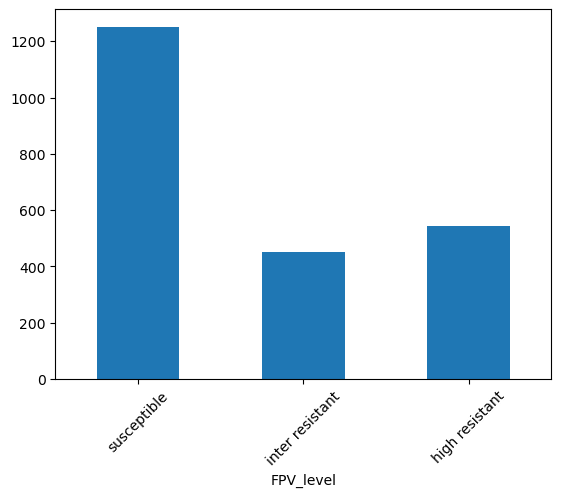

In [35]:
#checking the class imbalance per drug:

files = [r"data/PI_DataSet.txt", r"data/INI_DataSet.txt", r"data/NRTI_DataSet.txt", r"data/NNRTI_DataSet.txt"]

for file in files:
    df = pd.read_csv(file, sep='\t')

    if file == r"data/INI_DataSet.txt":
        continue

    print(file.split("/")[-1].strip("_DataSet.txt"), ": ")

    #print(df)
    df = df.iloc[:,1:-1]
    #print(df2)

    #Checking how much data is available for each drug
    #print(df.loc[:,"FPV":"DRV"].count())

    #list of current drugs of the dataset
    drugs = [drug for drug in list(df.columns) if not drug.startswith("P") ]

    for drug in drugs:
        #print(drug)
        tmp_drugs = drugs.copy()
        #print(tmp_drugs)
        tmp_drugs.remove(drug)
        #print(tmp_drugs)
        last_col = list(df.columns)[-1]
        dataframe = df.drop(tmp_drugs, axis=1)

        #print(dataframe.head())

        dataframe = dataframe.dropna()


        # encoding the levels of susceptibility as 0 for susceptible, 1 as partly resistant and 2 as completly resistant
        dataframe.loc[dataframe[drug] < cutoff_df.loc[drug, "lower"], drug + "_level"] = 0
        dataframe.loc[dataframe[drug] >= cutoff_df.loc[drug, "upper"], drug + "_level"] = 2
        dataframe.loc[(dataframe[drug] >= cutoff_df.loc[drug, "lower"]) & (dataframe[drug] < cutoff_df.loc[drug, "upper"]), drug + "_level"] = 1

        class_counts = dataframe[(drug + "_level")].value_counts(sort=False).sort_index()

        print(drug, ":")
        print(class_counts)

        ax = class_counts.plot(kind="bar")
        ax.tick_params("x", rotation=45)
        ax.set_xticklabels(["susceptible", "inter resistant", "high resistant"])
        ax.set_title('Class abundancies for ' + drug)
        plt.show()
    print("------------------------------------------------------------------------------")


PI : 
2      54
3      30
4     321
5     420
6     297
7     247
8    1026
Name: count, dtype: int64


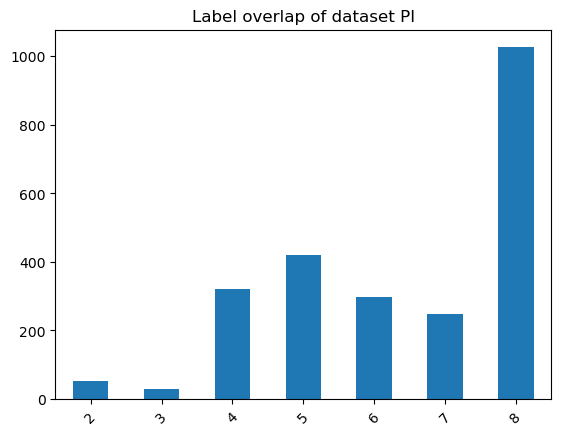

INI : 
1     51
2    456
3    104
4    154
Name: count, dtype: int64


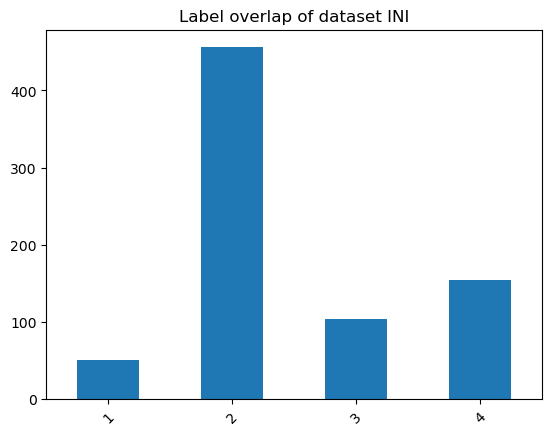

NRTI : 
1       8
2       4
3       4
4      15
5     462
6    1674
Name: count, dtype: int64


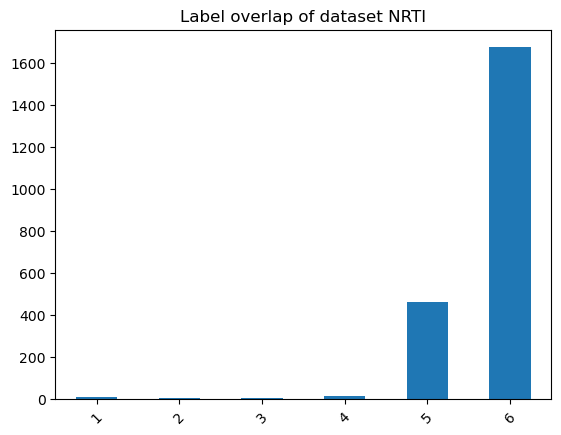

NNRTI : 
1      97
2    1252
3     767
4     173
Name: count, dtype: int64


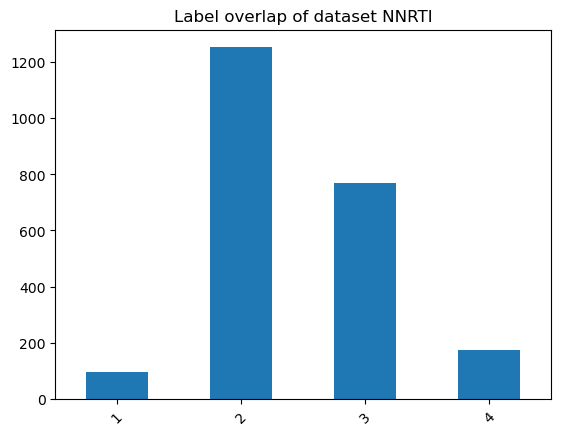

In [36]:
#checking the overlap of labels:

files = [r"data/PI_DataSet.txt", r"data/INI_DataSet.txt", r"data/NRTI_DataSet.txt", r"data/NNRTI_DataSet.txt"]

for file in files:
    df = pd.read_csv(file, sep='\t')

    print(file.split("/")[-1].strip("_DataSet.txt"), ": ")

    #print(df)
    df = df.iloc[:,1:-1]
    #print(df2)

    #Checking how much data is available for each drug
    #print(df.loc[:,"FPV":"DRV"].count())

    #list of current drugs of the dataset
    drugs = [drug for drug in list(df.columns) if not drug.startswith("P") ]

    labels = df.loc[:,drugs]

    '''if file == r"data/INI_DataSet.txt":
        print("INI CAB values: ", labels["CAB"].value_counts())
        print("---------------------------------------------------------")'''

    label_overlap = labels.count(axis=1).value_counts().sort_index()

    #print(labels)
    print(label_overlap)

    ax = label_overlap.plot(kind="bar")
    ax.tick_params("x", rotation=45)
    #ax.set_xticklabels(["susceptible", "inter resistant", "high resistant"])
    ax.set_title('Label overlap of dataset ' + file.split("/")[-1].strip("_DataSet.txt"))
    plt.show()
